# Analysis of Daily Historical Meteorologic Variables from LOCA and BCSD, Annual Max

This notebook analyzes meteorologic variables from the historical scenario ...

Variables include:
- Precipitation
- Temperature
- Annual Max
- Wet day fraction

TODO: still working on reading in hydro data

In [1]:
from loca import print_date
print_date()

Last executed: 2019-06-20 14:17:41.983103 by jvano on r6i6n30


# Imports and Options

In [8]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import warnings
import glob

import matplotlib.pyplot as plt

import xarray as xr
import cmocean

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change

# list of 25: 
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
          'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
          'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
          'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5'] 

# list to be plotted as individual gcms
models_ind_plot = ['ACCESS1-0', 'CanESM2', 'MIROC5'] 

met_vars = ['pcp', 't_mean']
hydro_met = 'met'  #or met hydro

if hydro_met == 'hydro':
    var3= 'total_runoff'
if hydro_met == 'met':
    var3 = 'pcp'
    
rcp = 'rcp45'  # or 'rcp85' 'rcp45'

read_cache = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.13:50324 Dashboard: proxy/8787/status,Cluster Workers: 36 Cores: 144 Memory: 435.96 GB


# Load Data

In [6]:
# client.restart()

load_monthly_historical_met_datasets
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_livneh_meteorology
load_daily_livneh_meteorology
load_monthly_maurer_meteorology
load_daily_maurer_meteorology


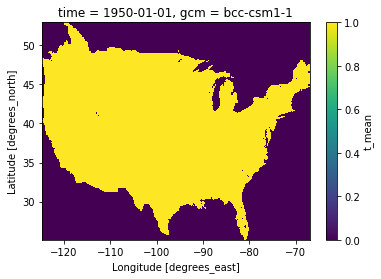

In [4]:
# just to get mask.  TODO: faster way to do this! 
met_data = load_monthly_historical_met_datasets(models=['bcc-csm1-1'], autoclose=True, parallel=True)
mask = met_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()
mask.plot()

In [8]:
# test = load_daily_livneh_meteorology(resolution='8th')

In [5]:
# display(met_data)
# livneh = met_data['livneh']['t_mean'].isel(time=0).squeeze().notnull()

In [9]:
methods = ['bcsd', 'loca']
gard_methods = ['AR_uvq', 'AR_puv', 'PT_p']

def get_data(stat, gcms=models, methods=methods, gard_methods=gard_methods):
    ds_dict = {}

    for scen in ['hist', 'rcp45', 'rcp85']:
        concat_methods = []
        ds_list = []
        for method in methods:
#             fname = '/glade/u/home/jvano/workdir/stats/{stat}_{method}_{scen}_{gcm}.nc'
            fname = '/glade/u/home/jvano/workdir/stats/{stat}_{hydro_met}_{method}_{scen}_{gcm}.nc'
            files = [fname.format(stat=stat, hydro_met=hydro_met, method=method, scen=scen, gcm=gcm) for gcm in gcms]
            ds = xr.open_mfdataset(files, concat_dim=xr.Variable('gcm', gcms))
            # special handling for gard
            if 'config' in ds.dims:
                for gm in gard_methods:
                    if 'lat' in ds:
                        ds = ds.drop(['lat', 'lon']).rename({'y': 'lat', 'x': 'lon'})
                    concat_methods.append(gm)
                    ds_list.append(ds.sel(config=gm).drop('config'))
            else:
                concat_methods.append(method)
                ds_list.append(ds)
        ds_dict[scen] = xr.concat(ds_list, dim=xr.Variable('dsmethod', concat_methods)).where(mask)
    return ds_dict

In [81]:
# #  fpath = os.path.join(MAURER_VIC_ROOT_DIR, '*nc')
# #     ds = xr.open_mfdataset(fpath, preprocess=drop_bound_varialbes, **kwargs)

# stat = 'mean'
# hydro_met = 'met'
# method = 'bcsd'
# scen = 'obs'


# file = f'/glade/u/home/jvano/workdir/stats/{stat}_{hydro_met}_{method}_{scen}_maurer.nc'
# display (file)
# ds2 = xr.open_mfdataset(file)

# test = 

# display(test)
   
# # observations= ['maurer']
# # get_data_obs('mean')

In [10]:
ds_dict = {}
ds_dict = {"mean": get_data('mean'), "annmax": get_data('annmax'), "wetfrac": get_data('wetfrac')}

In [143]:
# ds_dict['annmax']['rcp85']['pcp'].sel(gcm='ACCESS1-0')

<xarray.DataArray 'pcp' (dsmethod: 2, lat: 222, lon: 462)>
dask.array<shape=(2, 222, 462), dtype=float64, chunksize=(1, 222, 462)>
Coordinates:
  * lat       (lat) float64 25.19 25.31 25.44 25.56 ... 52.44 52.56 52.69 52.81
  * lon       (lon) float64 -124.7 -124.6 -124.4 -124.3 ... -67.31 -67.19 -67.06
    gcm       <U14 'ACCESS1-0'
  * dsmethod  (dsmethod) <U4 'bcsd' 'loca'
    time      datetime64[ns] 1950-01-01

# Plots

For the daily variables, we will make plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [13]:
var1 = 'wetfrac' # could be: mean, annmax, or wetfrac
dayconvert = {'mean': 365.25, 'annmax': 1, 'wetfrac': 1}
names = {'mean': 'Average', 'annmax': 'Annual Max', 'wetfrac': 'Wet Day Fraction'}

maurer = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_bcsd_obs_maurer.nc').where(mask) * dayconvert[var1]
livneh = xr.open_mfdataset(f'/glade/u/home/jvano/workdir/stats/{var1}_{hydro_met}_loca_obs_livneh.nc').where(mask) * dayconvert[var1]
ens_means = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').mean('gcm') * dayconvert[var1],
             "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').mean('gcm') * dayconvert[var1]}
ens_stds = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').std('gcm') * dayconvert[var1],
            "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').std('gcm') * dayconvert[var1]}
indiv = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd') * dayconvert[var1],
         "loca": ds_dict[var1]['hist'].sel(dsmethod='loca') * dayconvert[var1]}

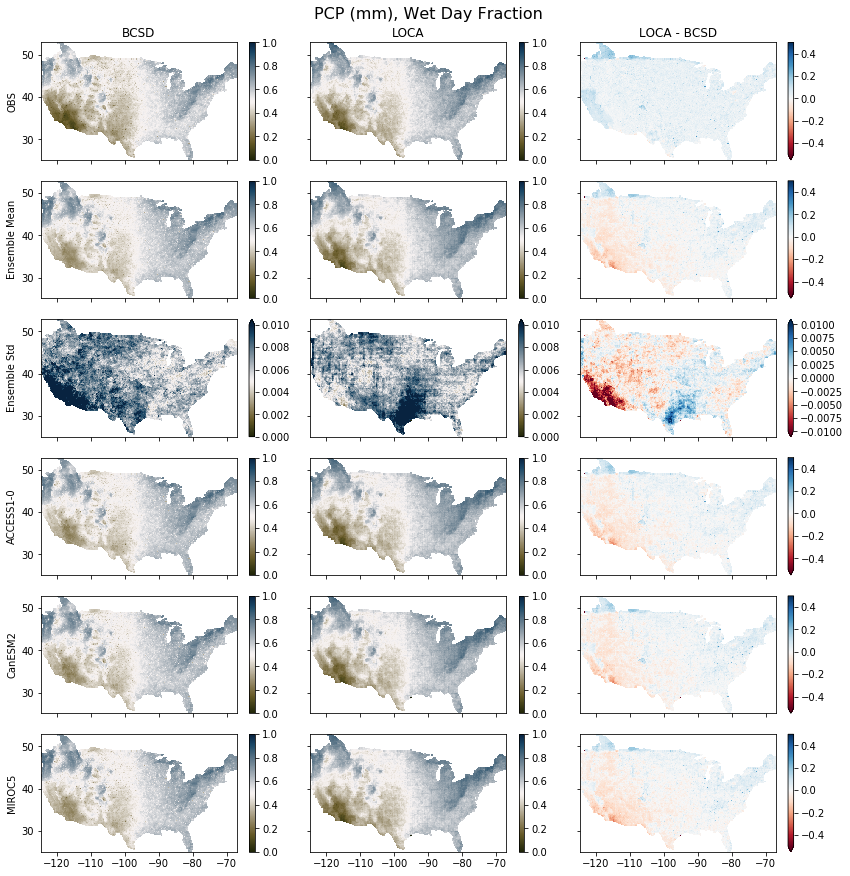

In [14]:
#  Average (should match figures of monthly values)

yr_type = 'A'

units = {'pcp': 'mm', 't_mean': 'C', 'total_runoff': 'mm'}

if var1 == 'mean':
    kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},'t_mean': {'vmin': -10, 'vmax': 20}}
    std_kwargs = {'pcp': {'vmin': 0, 'vmax': 40}}
    diff_kws = {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
    diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}

if var1 == 'annmax':
    kwargs = {'pcp': {'vmin': 0, 'vmax': 80},'t_mean': {'vmin': -10, 'vmax': 20},
              'total_runoff': {'vmin': 0, 'vmax': 40}}
    std_kwargs = {'pcp': {'vmin': 0, 'vmax': 8}, 'total_runoff': {'vmin': 0, 'vmax': 8}}
    diff_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}, 
                'total_runoff': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}
    diff_std_kws = {'pcp': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}, 'total_runoff': {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}}

if var1 == 'wetfrac':
    kwargs = {'pcp': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r}, 'total_runoff': {'vmin': 0, 'vmax': 1, 'cmap': cmocean.cm.diff_r}}
    std_kwargs = {'pcp': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r},'total_runoff': {'vmin': 0, 'vmax': .01, 'cmap': cmocean.cm.diff_r}}
    diff_kws = {'pcp': {'vmin': -0.5, 'vmax': 0.5, 'cmap': 'RdBu'}, 'total_runoff': {'vmin': -0.5, 'vmax': 0.5, 'cmap': 'RdBu'}}
    diff_std_kws = {'pcp': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu'}, 'total_runoff': {'vmin': -.01, 'vmax': .01, 'cmap': 'RdBu'}}

    
nrows = 3 + len(models_ind_plot)
ncols = 3

# met_vars = ['t_mean', 'pcp']

if hydro_met == 'hydro':
    met_vars = ['total_runoff']
if hydro_met == 'met':
    met_vars = ['pcp']

for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
    for col, (title, obs_data, ens_mean, ens_std, ds_data) in enumerate([('BCSD', maurer, ens_means['bcsd'], 
                                                                          ens_stds['bcsd'], indiv['bcsd']),
                                                                         ('LOCA', livneh, ens_means['loca'], 
                                                                          ens_stds['loca'], indiv['loca'])]):
        ax = axes[0, col]
        obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])  #commented out if can't read obs (for hydrology)
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('OBS')
        
        ax = axes[1, col]
        ens_mean[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
            
        ax = axes[2, col]
        ens_std[var].plot.pcolormesh(ax=ax, add_labels=False, **std_kwargs[var])
        if col == 0:
            ax.set_ylabel('Ensemble Std')
        
        for row, model in enumerate(models_ind_plot, 3):
            ax = axes[row, col]
            ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            
            if col == 0:
                ax.set_ylabel(model)
                
# DIFF        
    ax = axes[0, -1]
    calc_change(maurer[var], livneh[var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])  #commented out for now (until read in obs)
    ax.set_title('LOCA - BCSD')  
        
    ax = axes[1, -1]
    calc_change(ens_means['bcsd'][var], ens_means['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])

    ax = axes[2, -1]
    calc_change(ens_stds['bcsd'][var], ens_stds['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_std_kws[var])

    diff = calc_change(indiv['bcsd'][var], indiv['loca'][var]).persist()
    
    for row, model in enumerate(models_ind_plot, 3):
        ax = axes[row, -1]  
        diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var])

    title = var.upper()
    title += ' (%s),' % units[var]
    title += ' %s' % names[var1]
    unit_str = units[var]
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var1}_{unit_str}_daily_historic_{hydro_met}.png', dpi=300, bbox_inches='tight')

In [88]:
# var1 = 'mean' # or 'mean' 'annmax' 'wetfrac'
# dayconvert = {'mean': 365.25, 'annmax': 1, 'wetfrac': 1}
# names = {'mean': 'Average', 'annmax': 'Annual Max', 'wetfrac': 'Wet Day Fraction'}

# ens_means = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').mean('gcm') * dayconvert[var1],
#              "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').mean('gcm') * dayconvert[var1]}
# ens_stds = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd').std('gcm') * dayconvert[var1],
#             "loca": ds_dict[var1]['hist'].sel(dsmethod='loca').std('gcm') * dayconvert[var1]}
# indiv = {"bcsd": ds_dict[var1]['hist'].sel(dsmethod='bcsd') * dayconvert[var1],
#          "loca": ds_dict[var1]['hist'].sel(dsmethod='loca') * dayconvert[var1]}

In [68]:
# Plotting differences

ds_dict2 = get_data(var1)
pct = 'True'
da = calc_change(ds_dict2['hist'][var3], ds_dict2[rcp][var3], pct=pct)     

<xarray.DataArray 'total_runoff' (lat: 222, lon: 462)>
dask.array<shape=(222, 462), dtype=float32, chunksize=(222, 462)>
Coordinates:
  * lat       (lat) float64 25.19 25.31 25.44 25.56 ... 52.44 52.56 52.69 52.81
  * lon       (lon) float64 -124.7 -124.6 -124.4 -124.3 ... -67.31 -67.19 -67.06
    gcm       <U14 'ACCESS1-0'
    dsmethod  <U4 'loca'
    time      datetime64[ns] 1950-01-01

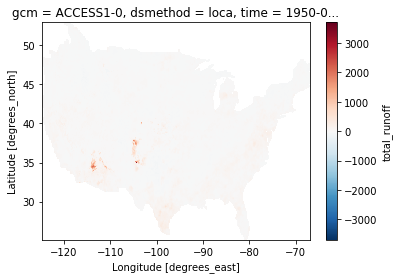

In [69]:
# display (ds_dict)
# display (da.sel(dsmethod='bcsd'))

da_ens_means = {"bcsd": da.sel(dsmethod='bcsd').mean('gcm'),
               "loca": da.sel(dsmethod='loca').mean('gcm')}
da_ens_stds = {"bcsd": da.sel(dsmethod='bcsd').std('gcm'),
               "loca": da.sel(dsmethod='loca').std('gcm')}
da_indiv = {"bcsd": da.sel(dsmethod='bcsd'), "loca": da.sel(dsmethod='loca')}
display (da_indiv['loca'].sel(gcm='ACCESS1-0'))
da_indiv['loca'].sel(gcm='ACCESS1-0').plot()

NameError: name 'da_ens_means' is not defined

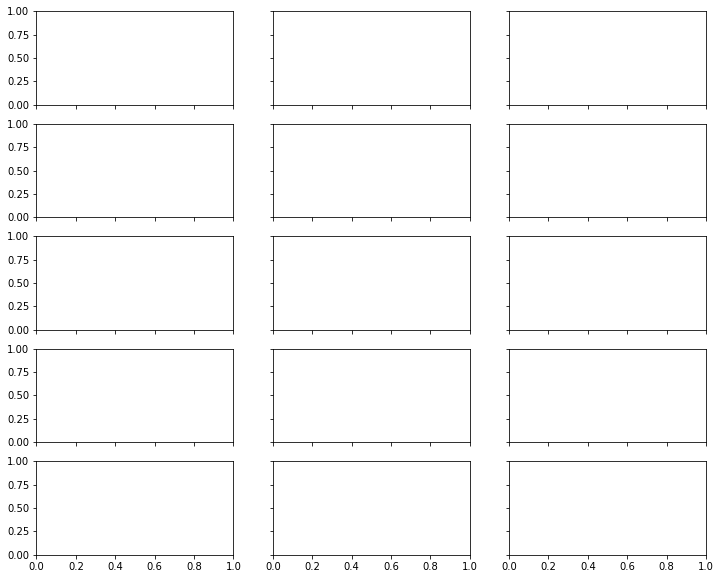

In [12]:
# models_ind_plot = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

models_ind_plot = ['ACCESS1-0', 'CanESM2', 'MIROC5']
longname = {'rcp85': 'RCP 8.5', 'rcp45': 'RCP 4.5'}

nrows = 2 + len(models_ind_plot)
ncols = 3

units = {'pcp': 'mm', 't_mean': 'C'}

if var1 == 'annmax':
    kwargs = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': 'RdBu'},'t_mean': {'vmin': -10, 'vmax': 20},
              'total_runoff': {'vmin': -120, 'vmax': 120, 'cmap': 'RdBu'}}
    diff_kws = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu'}, 
                'total_runoff': {'vmin': -120, 'vmax': 120, 'cmap': 'RdBu'}}
    std_kwargs = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}, 
                  'total_runoff': {'vmin': -60, 'vmax': 60, 'cmap': 'RdBu'}}
    diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'},
                    'total_runoff': {'vmin': -60, 'vmax': 60, 'cmap': 'RdBu'}}
                
if var1 == 'mean':
    kwargs = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': cmocean.cm.diff_r},'t_mean': {'vmin': -10, 'vmax': 20}}
    diff_kws = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
    std_kwargs = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': cmocean.cm.diff_r}}
    diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}
    
if var1 == 'wetfrac':
    kwargs = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': cmocean.cm.diff_r},'t_mean': {'vmin': -10, 'vmax': 20},}
    diff_kws = {'pcp': {'vmin': -40, 'vmax': 40, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}}
    std_kwargs = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': cmocean.cm.diff_r}}
    diff_std_kws = {'pcp': {'vmin': -20, 'vmax': 20, 'cmap': 'RdBu'}}
    
    
    
# met_vars = ['t_mean', 'pcp']
met_vars = ['pcp']

for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))
        
    for col, (title, ens_mean, ens_std, ds_data) in enumerate([('BCSD', da_ens_means['bcsd'], da_ens_stds['bcsd'], da_indiv['bcsd']),
                                                                         ('LOCA', da_ens_means['loca'], da_ens_stds['loca'], da_indiv['loca'])]):
        ax = axes[0, col]
        ens_mean.plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var3])
        ax.set_title(title)
        
        if col == 0:
            ax.set_ylabel('Ensemble Mean')
            
        ax = axes[1, col]
        ens_std.plot.pcolormesh(ax=ax, add_labels=False, **std_kwargs[var3])
        
        if col == 0:
            ax.set_ylabel('Ensemble Std')
        
        for row, model in enumerate(models_ind_plot, 2):
            ax = axes[row, col]
            ds_data.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var3])
            
            if col == 0:
                ax.set_ylabel(model)
                
# DIFF        
    ax = axes[0, -1]
    calc_change(da_ens_means['bcsd'], da_ens_means['loca']).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var3])
    ax.set_title('LOCA - BCSD')  
        
    ax = axes[1, -1]
    calc_change(da_ens_stds['bcsd'], da_ens_stds['loca']).plot.pcolormesh(ax=ax, add_labels=False, **diff_std_kws[var3])

    ax = axes[2, -1]
#     calc_change(ens_stds['bcsd'][var], ens_stds['loca'][var]).plot.pcolormesh(ax=ax, add_labels=False, **diff_std_kws[var])

    diff = calc_change(da_indiv['bcsd'], da_indiv['loca']).persist()
    
    for row, model in enumerate(models_ind_plot, 2):
        ax = axes[row, -1]  
        diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[var3])
        
        
    title = names[var1]
    title += ' (%), ' 
    title += longname[rcp]
    unit_str = 'pct'
    fig.suptitle(title, fontsize=16, y=1.01)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var1}_{unit_str}_daily_future_{rcp}_{hydro_met}.png', dpi=300, bbox_inches='tight')

In [47]:
# cleanup 
plt.close('all')